# Model Development

In [138]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import tqdm
import re
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

from ml_utils.preprocessing import target_melt
from ml_utils.tools import format_timedelta
import datetime

In [2]:
vcdb = pd.read_excel('data/vcdb_decoded.xlsx')

In [3]:
pd.__version__

'1.0.1'

In [4]:
with open('data/vcdb-enum.json') as f:
    enums = json.load(f)
    
with open('data/vcdb-merged.json') as f:
    schema = json.load(f)

In [5]:
keynames = []
with open('data/vcdb-keynames-real.txt') as f:
    for line in f:
        keynames.append(line.replace('\n', ''))
        

# Creating a configuration file / data dictionary

In [6]:
config = {
    'base_data': {},
    'targets': {}
}

# One-hot encoded features

In [7]:
ohe_cols = [col for col in vcdb if vcdb[col].isin([True, False]).all()]
print('%s hot encoded features'%len(ohe_cols))
      
assert vcdb[ohe_cols].notnull().all().all()
assert len(ohe_cols) == len(vcdb.select_dtypes('bool').columns)

476 hot encoded features


In [8]:
config['base_data']['one-hot encoded'] = ohe_cols

# Null Columns

In [9]:
null_cols = vcdb.columns[vcdb.isnull().all()]
null_cols = [col for col in null_cols if col not in ohe_cols]
print('%s completely null features'%len(null_cols))
config['base_data']['all null'] = null_cols

91 completely null features


Some of these are fine because they are one_hot encoded columns

In [10]:
some_nulls = [col for col in vcdb.columns[vcdb.isnull().any()] if col not in null_cols]
print('%s features with some nulls'%len(some_nulls))
config['base_data']['some null'] = some_nulls

115 features with some nulls


## Null categorical features with an Unknown category
We replace columns with "Unknown" as a value with pandas nulls, this way we can figure out a good imputation strategy for these rather than treat "unknown" as a category, since it is not useful to us.

In [11]:
ukn_cols = [col for col in some_nulls if (vcdb[col].astype(str).str.lower()=='unknown').any()]
for col in ukn_cols:
    vcdb.loc[vcdb[col].astype(str).str.lower()=='unknown', col] = None

assert not vcdb[ukn_cols].apply(lambda col: (col.astype(str).str.lower()=='unknown').any()).any()
config['base_data']['explicitly unknown'] = ukn_cols

# Data Types

### Floats

In [12]:
vcdb.select_dtypes('float64').notnull().sum().sort_values(ascending=False)

attribute.confidentiality.data_total                 4394
attribute.confidentiality.data.amount.Medical        1711
attribute.confidentiality.data.amount.Personal       1192
victim.locations_affected                            1185
victim.revenue.amount                                 505
                                                     ... 
asset.assets.amount.U - Telephone                       0
asset.assets.amount.U - Unknown                         0
asset.assets.amount.U - VoIP phone                      0
attribute.confidentiality.data.amount.Source code       0
asset.assets.amount.E - Other                           0
Length: 149, dtype: int64

In [13]:
vcdb.dtypes.value_counts()

bool       476
float64    149
object      66
int64        1
dtype: int64

In [14]:
float_cols = [col for col in vcdb.select_dtypes('float64') if not vcdb[col].isnull().all()]
len(float_cols)
config['base_data']['floats'] = float_cols

## Free Text

In [15]:
text_cols = [col for col in vcdb if 'notes' in col.lower() or 'summary' in col.lower()]
text_cols += ['reference']
text_cols

['action.environmental.notes',
 'action.error.notes',
 'action.hacking.notes',
 'action.malware.notes',
 'action.misuse.notes',
 'action.physical.notes',
 'action.social.notes',
 'action.unknown.notes',
 'asset.notes',
 'attribute.availability.notes',
 'attribute.confidentiality.notes',
 'attribute.integrity.notes',
 'discovery_notes',
 'impact.notes',
 'notes',
 'plus.analyst_notes',
 'plus.event_chain.summary',
 'plus.pci.notes',
 'summary',
 'victim.notes',
 'victim.secondary.notes',
 'reference']

In [16]:
vcdb[text_cols].notnull().sum()

action.environmental.notes            1
action.error.notes                  299
action.hacking.notes                192
action.malware.notes                102
action.misuse.notes                 118
action.physical.notes                30
action.social.notes                  60
action.unknown.notes                  5
asset.notes                         173
attribute.availability.notes        114
attribute.confidentiality.notes     727
attribute.integrity.notes           234
discovery_notes                     415
impact.notes                        133
notes                               423
plus.analyst_notes                  167
plus.event_chain.summary              0
plus.pci.notes                        0
summary                            7329
victim.notes                         62
victim.secondary.notes               74
reference                          7379
dtype: int64

## Text cleaning

In [17]:
cat_and_text_cols = vcdb.select_dtypes('O').columns
for col in cat_and_text_cols:
    vcdb[col] = (
        vcdb[col]
            .fillna('placeholder_nan')
            .astype(str)
            .str.lower()
            .replace('placeholder_nan', np.nan)
    )

## Categoricals

In [18]:
{col: vcdb[col].unique() for col in vcdb if 'cve' in col}

{'action.hacking.cve': array([nan, 'cve-2008-4250', 'heartbleed', 'cve-2012-0507',
        'unknown vuln', 'cve-2016-6483', 'cve unknown', 'cve-2012-5385',
        'cve-2014-0160', 'cve-2017-5638', 'cve-2012-4969', 'cve-2013-0632',
        'cve-2013-1347,cve-2013-2423,cve-2013-1493', 'cve-2017-0144',
        'wordpress'], dtype=object),
 'action.malware.cve': array([nan, 'cve-2010-0249',
        'cve-2009-3129, cve-2010-3333, cve-2012-0158, cve-2011-3544',
        'cve-2013-0640,cve-2013-0641', 'cve-2012-4681;cve-2013-2423',
        'cve-2013-3893', 'cve 2012-4792',
        'cve-2013-1347, cve-2013-2423, cve-2013-1493', 'cve-2012-4681'],
       dtype=object)}

In [19]:
feature_counts = {}
for col in vcdb.select_dtypes('O'):
    if 'notes' not in col.lower() and col not in ohe_cols:
        feature_counts[col]= vcdb[col].nunique()
feature_counts

{'action.hacking.cve': 14,
 'action.malware.cve': 8,
 'action.malware.name': 21,
 'campaign_id': 10,
 'control_failure': 1,
 'incident_id': 7829,
 'plus.analyst': 69,
 'plus.asset.total': 3,
 'plus.attribute.confidentiality.credit_monitoring': 5,
 'plus.attribute.confidentiality.data_abuse': 3,
 'plus.attribute.confidentiality.data_misuse': 4,
 'plus.attribute.confidentiality.partner_data': 2,
 'plus.f500': 6,
 'plus.github': 4344,
 'plus.master_id': 7832,
 'plus.sub_source': 4,
 'reference': 5925,
 'schema_version': 2,
 'source_id': 1,
 'summary': 6936,
 'victim.industry': 670,
 'victim.region': 38,
 'victim.secondary.victim_id': 234,
 'victim.state': 97,
 'victim.victim_id': 5616,
 'victim.industry3': 115,
 'victim.industry.name': 21,
 'pattern': 10,
 'security_incident': 3,
 'impact.overall_rating': 4,
 'impact.iso_currency_code': 10,
 'confidence': 4,
 'victim.employee_count': 11,
 'victim.country': 134,
 'victim.revenue.iso_currency_code': 2,
 'victim.orgsize': 2,
 'attribute.avai

In [20]:
vcdb[feature_counts.keys()]

,action.hacking.cve,action.malware.cve,action.malware.name,campaign_id,control_failure,incident_id,plus.analyst,plus.asset.total,plus.attribute.confidentiality.credit_monitoring,plus.attribute.confidentiality.data_abuse,...,targeted,cost_corrective_action,asset.cloud,asset.accessibility,asset.country,plus.analysis_status,plus.attack_difficulty_initial,plus.attack_difficulty_legacy,plus.attack_difficulty_subsequent,plus.unknown_unknowns
0,NaN,NaN,NaN,NaN,NaN,0001aa7f-c601-424a-b2b8-be6c9f5164e7,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0008dadb-e83d-4278-a19a-cee01610cf43,swidup,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,000d403e-2dc9-4ea7-9294-bd3938d1c3c7,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0012cc25-9167-40d8-8fe3-3d0dfd8fb6bb,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,00163384-b4d7-46d5-9e6f-543dfb00f598,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,NaN,NaN,NaN,NaN,NaN,b533254c-4713-4fe7-a9f8-412abb4ec664,robert-topper,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,finalized,NaN,NaN,NaN,NaN
7829,NaN,NaN,NaN,NaN,NaN,ffd31fe4-976b-48ca-a111-ef84ebab9b0f,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7830,NaN,NaN,NaN,NaN,NaN,ffda2281-8053-4315-b613-330eb09a4bee,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7831,NaN,NaN,NaN,NaN,NaN,ffdc6655-e421-4bec-835f-1bdfec4f6c70,swidup,no,u,u,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN


In [21]:
def id_generator(dict_var, key):
    """
    Based.
    https://stackoverflow.com/questions/21028979/recursive-iteration-through-nested-json-for-specific-key-in-python
    """
    for k, v in dict_var.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for id_val in id_generator(v, key):
                yield id_val

In [22]:
enums = set()
for enum in id_generator(schema,'enum'):
    enums.add(tuple(enum))

len(enums)

66

In [23]:
pd.Categorical(vcdb['security_incident']).categories

Index(['confirmed', 'near miss', 'suspected'], dtype='object')

# Target Variable Analysis

We start by having at some Incident Description Enumerations to see what is feasible.

#### SECURITY_INCIDENT
- Confirmed: Yes - Confirmed
- Suspected: Suspected
- False positive: False positive (response triggered, but no incident)
- Near miss: Near miss (actions did not compromise asset)

In [24]:
config['targets']['All'] = []

In [25]:
schema['properties']['security_incident']

{'type': 'string',
 'description': 'Confirmed incident?',
 'enum': ['Confirmed', 'Suspected', 'Near miss', 'False positive']}

In [26]:
vcdb['security_incident'].value_counts(dropna=False)

confirmed    7759
suspected      67
near miss       6
NaN             1
Name: security_incident, dtype: int64

In [27]:
config['targets']['All'].append('security_incident')

In [28]:
impact_cols = [col for col in vcdb if col.startswith('impact')]

In [29]:
vcdb[[col for col in vcdb if col.startswith('impact')]].notnull().sum()

impact.loss.amount             0
impact.notes                 133
impact.overall_amount         80
impact.overall_max_amount      1
impact.overall_min_amount      2
impact.overall_rating         27
impact.iso_currency_code     197
dtype: int64

In [30]:
vcdb['impact.overall_rating'].value_counts(dropna=False)

NaN              7806
distracting        13
damaging            8
painful             5
insignificant       1
Name: impact.overall_rating, dtype: int64

In [31]:
config['targets']['All'] += [col for col in vcdb if col.startswith('impact')]

# Predicting C-I-A outcomes

In [32]:
cia_cols = [col for col in vcdb if col.startswith('attribute.')]
config['targets']['All CIA'] = cia_cols

Data Disclosure looks promising as a decision outcome: while there is a class imbalance it is not as extreme as that of security_incidents

In [33]:
vcdb['attribute.confidentiality.data_disclosure'].value_counts()

yes            5076
potentially    1884
no               76
Name: attribute.confidentiality.data_disclosure, dtype: int64

In [34]:
config['targets']['data_disclosure'] = 'attribute.confidentiality.data_disclosure'

Availability Duration does not seem promising as a decision outcome

In [35]:
config['targets']['All'] += [col for col in vcdb if col.startswith('attribute')]

In [36]:
vcdb['attribute.Confidentiality'].value_counts()

True     7249
False     584
Name: attribute.Confidentiality, dtype: int64

In [37]:
[col for col in vcdb if col.startswith('attribute.confidentiality') and 'variety' in col]

['attribute.confidentiality.data.variety.Bank',
 'attribute.confidentiality.data.variety.Classified',
 'attribute.confidentiality.data.variety.Copyrighted',
 'attribute.confidentiality.data.variety.Credentials',
 'attribute.confidentiality.data.variety.Digital certificate',
 'attribute.confidentiality.data.variety.Internal',
 'attribute.confidentiality.data.variety.Medical',
 'attribute.confidentiality.data.variety.Other',
 'attribute.confidentiality.data.variety.Payment',
 'attribute.confidentiality.data.variety.Personal',
 'attribute.confidentiality.data.variety.Secrets',
 'attribute.confidentiality.data.variety.Source code',
 'attribute.confidentiality.data.variety.System',
 'attribute.confidentiality.data.variety.Unknown',
 'attribute.confidentiality.data.variety.Virtual currency']

In [38]:
vcdb['attribute.Integrity'].value_counts()

False    5998
True     1835
Name: attribute.Integrity, dtype: int64

In [39]:
[col for col in vcdb if col.startswith('attribute.integrity')]

['attribute.integrity.notes',
 'attribute.integrity.variety.Alter behavior',
 'attribute.integrity.variety.Created account',
 'attribute.integrity.variety.Defacement',
 'attribute.integrity.variety.Fraudulent transaction',
 'attribute.integrity.variety.Hardware tampering',
 'attribute.integrity.variety.Log tampering',
 'attribute.integrity.variety.Misrepresentation',
 'attribute.integrity.variety.Modify configuration',
 'attribute.integrity.variety.Modify data',
 'attribute.integrity.variety.Modify privileges',
 'attribute.integrity.variety.Other',
 'attribute.integrity.variety.Repurpose',
 'attribute.integrity.variety.Software installation',
 'attribute.integrity.variety.Unknown']

In [40]:
vcdb['attribute.Availability'].value_counts()

False    5486
True     2347
Name: attribute.Availability, dtype: int64

In [41]:
[col for col in vcdb if col.startswith('attribute.availability')]

['attribute.availability.duration.value',
 'attribute.availability.notes',
 'attribute.availability.variety.Acceleration',
 'attribute.availability.variety.Degradation',
 'attribute.availability.variety.Destruction',
 'attribute.availability.variety.Interruption',
 'attribute.availability.variety.Loss',
 'attribute.availability.variety.Obscuration',
 'attribute.availability.variety.Other',
 'attribute.availability.variety.Unknown',
 'attribute.availability.duration.unit']

In [42]:
vcdb['attribute.availability.duration.value'].notnull().sum()

106

In [43]:
vcdb['control_failure'].value_counts(dropna=False)

NaN                             7832
single factor authentication       1
Name: control_failure, dtype: int64

## Predicting Pattern Outcomes

In [44]:
vcdb['pattern'].value_counts()

miscellaneous errors      1812
privilege misuse          1597
lost and stolen assets    1460
everything else           1026
web applications           896
payment card skimmers      278
crimeware                  267
cyber-espionage            247
denial of service          162
point of sale               88
Name: pattern, dtype: int64

In [45]:
config['targets']['All'].append('pattern')

In [46]:
pattern_cols = [col for col in vcdb if col.startswith('pattern.')]
pattern_cols

['pattern.Point of Sale',
 'pattern.Web Applications',
 'pattern.Privilege Misuse',
 'pattern.Lost and Stolen Assets',
 'pattern.Miscellaneous Errors',
 'pattern.Crimeware',
 'pattern.Payment Card Skimmers',
 'pattern.Denial of Service',
 'pattern.Cyber-Espionage',
 'pattern.Everything Else']

In [47]:
vcdb[pattern_cols].sum(axis=1).value_counts()

1    7732
2     101
dtype: int64

In [48]:
target_melt(vcdb, pattern_cols)['target'].value_counts(dropna=False)

Miscellaneous Errors      1812
Privilege Misuse          1604
Lost and Stolen Assets    1505
Everything Else           1026
Web Applications           900
Payment Card Skimmers      290
Cyber-Espionage            280
Crimeware                  267
Denial of Service          162
Point of Sale               88
Name: target, dtype: int64

In [49]:
config['targets']['All'] += pattern_cols

## Actions as Outcomes or Features

In [50]:
vcdb['action.Social'].value_counts()

False    7318
True      515
Name: action.Social, dtype: int64

#### Action Results are very null

In [51]:
vcdb[[col for col in vcdb if col.startswith('action.') and 'result' in col]].sum(axis=1).value_counts()

0    7555
1     199
2      77
3       2
dtype: int64

#### Action Variety Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [52]:
action_variety_cols = [col for col in vcdb if col.startswith('action.') and 'variety' in col]
len(action_variety_cols)

155

In [53]:
vcdb[action_variety_cols].sum(axis=1).value_counts()

1     6273
2      935
0      210
3      172
13      88
9       74
4       42
5       26
6        9
7        3
8        1
dtype: int64

In [54]:
target_melt(vcdb, action_variety_cols, split=False)['target'].value_counts()

action.hacking.variety.Unknown                   1334
action.physical.variety.Theft                    1128
action.misuse.variety.Privilege abuse            1110
action.error.variety.Misdelivery                  910
action.error.variety.Loss                         391
                                                 ... 
action.hacking.variety.Mail command injection       1
action.hacking.variety.Reverse engineering          1
action.hacking.variety.Session fixation             1
action.social.variety.Spam                          1
action.environmental.variety.Humidity               1
Name: target, Length: 109, dtype: int64

#### Action Vector Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [55]:
action_vector_cols = [col for col in vcdb if col.startswith('action.') and 'vector' in col]
len(action_vector_cols)

66

In [56]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

#### Action Result Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [57]:
action_result_cols = [col for col in vcdb if col.startswith('action.') and 'result' in col]

In [58]:
target_melt(vcdb, action_result_cols, split=False)['target'].shape

(359,)

In [59]:
target_melt(vcdb, action_result_cols, split=False)['target'].value_counts()

action.misuse.result.Exfiltrate      82
action.hacking.result.Exfiltrate     63
action.physical.result.Exfiltrate    55
action.hacking.result.Infiltrate     49
action.malware.result.Exfiltrate     30
action.social.result.Exfiltrate      21
action.social.result.Infiltrate      15
action.malware.result.Infiltrate     14
action.physical.result.Infiltrate    10
action.unknown.result.Infiltrate      5
action.misuse.result.Infiltrate       5
action.unknown.result.Exfiltrate      4
action.social.result.Elevate          3
action.malware.result.Elevate         1
action.hacking.result.Elevate         1
action.physical.result.Elevate        1
Name: target, dtype: int64

In [60]:
target_melt(vcdb, action_vector_cols, split=False)['target'].value_counts()

action.error.vector.Unknown                  1301
action.hacking.vector.Web application        1028
action.misuse.vector.LAN access              1026
action.error.vector.Carelessness              895
action.hacking.vector.Unknown                 769
                                             ... 
action.hacking.vector.3rd party desktop         2
action.malware.vector.Software update           2
action.social.vector.Removable media            1
action.physical.vector.Visitor privileges       1
action.social.vector.IM                         1
Name: target, Length: 64, dtype: int64

In [61]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

### High Level Action
Potentially quite useful as a target variable?

i.e given properties about an organisation, what actions are most likely?

In [62]:
action_target_cols = [col for col in vcdb if col.startswith('action') and col.count('.')==1]
target_melt(vcdb, action_target_cols)['target'].value_counts(dropna=False)

Error            2266
Hacking          2078
Misuse           1604
Physical         1517
Malware           633
Social            515
Unknown           233
Environmental       8
Name: target, dtype: int64

# Model 1: Predicting Likelihood of Data Disclosure

In [63]:
id_cols = [col for col in vcdb if '_id' in col]
id_cols += ['plus.github']

In [64]:
y1 = (vcdb['attribute.confidentiality.data_disclosure'] == 'yes').astype(int)

In [65]:
y1.value_counts()

1    5076
0    2757
Name: attribute.confidentiality.data_disclosure, dtype: int64

In [66]:
dropped_cols = id_cols + text_cols + cia_cols + impact_cols + pattern_cols + null_cols + ['security_incident', 'plus.analyst', 'plus.analysis_status']
X1 = (
    vcdb
        .copy()
        .drop(labels = dropped_cols, axis=1)
)

In [67]:
X1['victim.industry2'] = X1['victim.industry2'].astype(str)
assert X1.select_dtypes('int64').empty

In [68]:
X1.select_dtypes('O').nunique().sort_values(ascending=False)

victim.industry                                     670
victim.country                                      134
victim.industry3                                    115
victim.state                                         97
victim.region                                        38
victim.industry2                                     26
action.malware.name                                  21
victim.industry.name                                 21
action.hacking.cve                                   14
victim.employee_count                                11
asset.country                                        11
pattern                                              10
action.malware.cve                                    8
plus.f500                                             6
plus.attack_difficulty_legacy                         5
asset.cloud                                           5
plus.attribute.confidentiality.credit_monitoring      5
plus.attribute.confidentiality.data_misuse      

In [69]:
feature_counts = {}
for col in X1.select_dtypes('O'):
    if 'notes' not in col.lower() and col not in ohe_cols:
        feature_counts[col]= vcdb[col].nunique()
feature_counts

{'action.hacking.cve': 14,
 'action.malware.cve': 8,
 'action.malware.name': 21,
 'control_failure': 1,
 'plus.asset.total': 3,
 'plus.attribute.confidentiality.credit_monitoring': 5,
 'plus.attribute.confidentiality.data_abuse': 3,
 'plus.attribute.confidentiality.data_misuse': 4,
 'plus.attribute.confidentiality.partner_data': 2,
 'plus.f500': 6,
 'plus.sub_source': 4,
 'schema_version': 2,
 'victim.industry': 670,
 'victim.region': 38,
 'victim.state': 97,
 'victim.industry2': 26,
 'victim.industry3': 115,
 'victim.industry.name': 21,
 'pattern': 10,
 'confidence': 4,
 'victim.employee_count': 11,
 'victim.country': 134,
 'victim.revenue.iso_currency_code': 2,
 'victim.orgsize': 2,
 'targeted': 2,
 'cost_corrective_action': 2,
 'asset.cloud': 5,
 'asset.accessibility': 1,
 'asset.country': 11,
 'plus.attack_difficulty_initial': 4,
 'plus.attack_difficulty_legacy': 5,
 'plus.attack_difficulty_subsequent': 4,
 'plus.unknown_unknowns': 2}

In [70]:
X1.select_dtypes('O').nunique()

action.hacking.cve                                   14
action.malware.cve                                    8
action.malware.name                                  21
control_failure                                       1
plus.asset.total                                      3
plus.attribute.confidentiality.credit_monitoring      5
plus.attribute.confidentiality.data_abuse             3
plus.attribute.confidentiality.data_misuse            4
plus.attribute.confidentiality.partner_data           2
plus.f500                                             6
plus.sub_source                                       4
schema_version                                        2
victim.industry                                     670
victim.region                                        38
victim.state                                         97
victim.industry2                                     26
victim.industry3                                    115
victim.industry.name                            

In [71]:
X1.dtypes.value_counts()

bool       409
float64     39
object      33
dtype: int64

## Split into Training and Test data

In [72]:
from ml_utils.preprocessing import CategoricalEncoder
from sklearn.model_selection import train_test_split

In [73]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=42)
X1_train.is_copy = None
X1_val.is_copy = None

In [74]:
cat_cols = list(X1.select_dtypes('O').columns)

In [75]:
X1_train.dtypes.value_counts()

bool       409
float64     39
object      33
dtype: int64

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from category_encoders import MEstimateEncoder

In [77]:
m_encoder = MEstimateEncoder(cols=cat_cols)

#### M-Estimator Encoder to encode categoricals

In [78]:
X1_train_encoded = m_encoder.fit_transform(X1_train, y1_train)
X1_val_encoded = m_encoder.transform(X1_val)

In [79]:
X1_train_encoded.loc[:, X1_train_encoded.isnull().any()].dtypes

asset.assets.amount.M - Disk drive               float64
asset.assets.amount.M - Disk media               float64
asset.assets.amount.M - Documents                float64
asset.assets.amount.M - Flash drive              float64
asset.assets.amount.M - Other                    float64
asset.assets.amount.M - Payment card             float64
asset.assets.amount.M - Smart card               float64
asset.assets.amount.M - Tapes                    float64
asset.assets.amount.N - Camera                   float64
asset.assets.amount.N - PLC                      float64
asset.assets.amount.P - End-user                 float64
asset.assets.amount.P - Finance                  float64
asset.assets.amount.P - Former employee          float64
asset.assets.amount.P - Human resources          float64
asset.assets.amount.P - Other                    float64
asset.assets.amount.P - Unknown                  float64
asset.assets.amount.S - Code repository          float64
asset.assets.amount.S - Databas

#### Use Iterative Imputer to impute the missing float values

In [80]:
t0 = datetime.datetime.now()
print('Fitting Iterative Imputer...')
print('----------------------------\n')
imputer = IterativeImputer(verbose=2)
X1_train_imputed = imputer.fit_transform(X1_train_encoded)

print('Iterative Imputer Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('----------------------------\n')

print('Transforming validation data....')
X1_val_imputed = imputer.transform(X1_val_encoded)

print('Validation data transformed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('----------------------------\n')


Fitting Iterative Imputer...
----------------------------

[IterativeImputer] Completing matrix with shape (6266, 476)
[IterativeImputer] Ending imputation round 1/10, elapsed time 115.48
[IterativeImputer] Change: 3212395.8526955494, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
Iterative Imputer Fitted!
Total Time Elapsed - 0:1:55
----------------------------

Transforming validation data....
[IterativeImputer] Completing matrix with shape (1567, 476)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.17
Validation data transformed!
Total Time Elapsed - 0:1:55
----------------------------



In [184]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, \
                            roc_curve, \
                            auc, \
                            classification_report, \
                            confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [123]:
assert pd.DataFrame(X1_train_imputed).notnull().all().all()
assert pd.DataFrame(X1_val_imputed).notnull().all().all()

#### Addressing Class Imbalance using ADASYN

In [103]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
sampler = SVMSMOTE()
print('Original no. training samples:', X1_train_imputed.shape[0])
X1_train_resampled, y1_train_resampled = sampler.fit_resample(X1_train_imputed, y1_train)
print('No. training samples ver oversampling:', X1_train_resampled.shape[0])

Original no. training samples: 6266
No. training samples ver oversampling: 8142


#### Training Time

In [ ]:
summary_report()

In [171]:
xgb1 = XGBClassifier(verbose = 3)
t0 = datetime.datetime.now()
print('---------------------------------------------------')

print('Fitting XGBoost...')
xgb1.fit(X1_train_resampled, y1_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('---------------------------------------------------')
print('Predicting on validation data...')
y1_pred_probas = xgb1.predict_proba(X1_val_imputed)
y1_pred_proba = y1_pred_probas[:,1]
y1_pred = xgb1.predict(X1_val_imputed)

print('Predictions Completed')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('---------------------------------------------------')
print('ROC-AUC Score: {:.2%}'.format(roc_auc_score(y1_val, y1_pred_proba)))
print('Accuracy Score: {:.2%}'.format(accuracy_score(y1_val, y1_pred)))
print('Precision Score: {:.2%}'.format(precision_score(y1_val, y1_pred)))
print('Recall Score: {:.2%}'.format(recall_score(y1_val, y1_pred)))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y1_val, y1_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y1_val, y1_pred)).loc[range(2), range(2)]
print(confusion)

---------------------------------------------------
Fitting XGBoost...
XGBoost Fitted!
Total Time Elapsed - 0:0:2
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:2
---------------------------------------------------
ROC-AUC Score: 88.48%
Accuracy Score: 83.73%
Precision Score: 84.98%
Recall Score: 90.65%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       562
           1       0.85      0.91      0.88      1005

    accuracy                           0.84      1567
   macro avg       0.83      0.81      0.82      1567
weighted avg       0.84      0.84      0.83      1567

---------------------------------------------------

Confusion Matrix:
     0    1
0  401  161
1   94  911


In [140]:
def plot_roc(y_test, y_proba):
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    # fpr, tpr, threshold = roc_curve(y1_val, y1_pred_proba)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

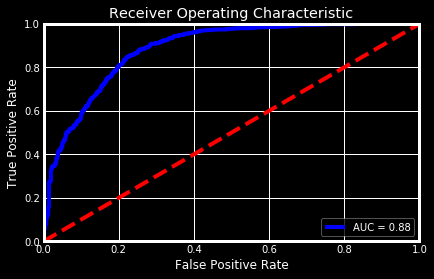

In [141]:
plot_roc(y1_val, y1_pred_proba)

## Hyperparameter Tuning using Particle Swarm Optimisation

In [86]:
import optunity
import optunity.metrics

#### Maximizing Area Under the Reciever Operating Curve

In [182]:
# Define our Objective Function
@optunity.cross_validated(x=X1_train_resampled, y=y1_train_resampled.values, num_folds=3)
# @optunity.cross_validated(x=X1_train_resampled, y=y1_train_resampled.values, num_folds=5)
def xgb_tuned_auroc(x_train, y_train, x_test, y_test, 
                    # These are the hyperparameters we wish to tune
                    n_estimators,
                    max_depth, 
                    min_child_weight, 
                    gamma, 
                    colsample_bytree,
                    subsample,
                    reg_alpha, 
                    reg_lambda):
    
# #     categorical encoding
#     print('M-encoding categoricals')
#     x_train_df = pd.DataFrame(x_train, columns = X1.columns)
#     x_test_df = pd.DataFrame(x_test, columns = X1.columns)
#     assert all([col in x_train_df for col in cat_cols])
    
#     m_encoder = MEstimateEncoder(cols=cat_cols)
#     x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
#     x_test_enc = m_encoder.transform(x_test_df)
    
#     # imputation
#     print('Imputing nulls')
#     imputer = IterativeImputer(verbose=2)
#     x_train_imp = imputer.fit_transform(x_train_enc)
#     x_test = imputer.transform(x_test_enc)
        
#     # oversampling
#     print('Oversampling')
#     oversampler = ADASYN()
#     x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 3
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
#     print('ROC-AUC Score= {:.2%}'.format(auc), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return auc

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

optimum, details, _ = optunity.maximize(xgb_tuned_auroc, 
                                        num_evals = 100, 
                                        # define hyperparameter grid
                                        n_estimators = [100, 1000], 
                                        max_depth = [2, 10], 
                                        min_child_weight = [1, 7],
                                        gamma = [0.1, 2],
                                        colsample_bytree = [0.3, 1],
                                        subsample = [0.2, 0.7],
                                        reg_alpha = [0, 1],
                                        reg_lambda = [1, 5]
                                       )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
optimum['n_estimators'] = round(optimum['n_estimators'])
optimum['max_depth'] = round(optimum['max_depth'])
print(optimum)

Tuning XGBoost...
----------------------------

Tuning Completed!
Total Time Elapsed - 0:19:3
{'n_estimators': 190, 'max_depth': 7, 'min_child_weight': 3.6693147106432553, 'gamma': 1.397307159004931, 'colsample_bytree': 0.5458988097440807, 'subsample': 0.661884765625, 'reg_alpha': 0.7258339593378564, 'reg_lambda': 2.9194222465779065}


---------------------------------------------------
Fitting XGBoost...
XGBoost Fitted!
Total Time Elapsed - 0:0:3
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:3
---------------------------------------------------
ROC-AUC Score: 87.98%
Accuracy Score: 81.62%
Precision Score: 84.31%
Recall Score: 87.66%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       562
           1       0.84      0.88      0.86      1005

    accuracy                           0.82      1567
   macro avg       0.80      0.79      0.80      1567
weighted avg       0.81      0.82      0.81      1567

---------------------------------------------------

Confusion Matrix:
     0    1
0  398  164
1  124  881


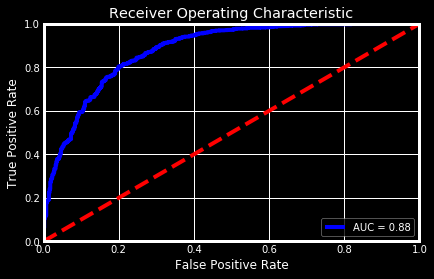

In [183]:
xgb1 = XGBClassifier(**optimum, verbose = 3)
t0 = datetime.datetime.now()
print('---------------------------------------------------')

print('Fitting XGBoost...')
xgb1.fit(X1_train_resampled, y1_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('---------------------------------------------------')
print('Predicting on validation data...')
y1_pred_probas = xgb1.predict_proba(X1_val_imputed)
y1_pred_proba = y1_pred_probas[:,1]
y1_pred = xgb1.predict(X1_val_imputed)

print('Predictions Completed')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('---------------------------------------------------')
print('ROC-AUC Score: {:.2%}'.format(roc_auc_score(y1_val, y1_pred_proba)))
print('Accuracy Score: {:.2%}'.format(accuracy_score(y1_val, y1_pred)))
print('Precision Score: {:.2%}'.format(precision_score(y1_val, y1_pred)))
print('Recall Score: {:.2%}'.format(recall_score(y1_val, y1_pred)))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y1_val, y1_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y1_val, y1_pred)).loc[range(2), range(2)]
print(confusion)

plot_roc(y1_val, y1_pred_proba)

#### Maximizing Area Under the Reciever Operating Curve

In [185]:
# Define our Objective Function
@optunity.cross_validated(x=X1_train_resampled, y=y1_train_resampled.values, num_folds=3)
# @optunity.cross_validated(x=X1_train_resampled, y=y1_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
# #     categorical encoding
#     print('M-encoding categoricals')
#     x_train_df = pd.DataFrame(x_train, columns = X1.columns)
#     x_test_df = pd.DataFrame(x_test, columns = X1.columns)
#     assert all([col in x_train_df for col in cat_cols])

#     m_encoder = MEstimateEncoder(cols=cat_cols)
#     x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
#     x_test_enc = m_encoder.transform(x_test_df)

#     # imputation
#     print('Imputing nulls')
#     imputer = IterativeImputer(verbose=2)
#     x_train_imp = imputer.fit_transform(x_train_enc)
#     x_test = imputer.transform(x_test_enc)
        
#     # oversampling
#     print('Oversampling')
#     oversampler = ADASYN()
#     x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 3
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    recall = recall_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_pred_proba)
#     print('ROC-AUC Score= {:.2%}'.format(auc), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return recall

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                        num_evals = 100, 
                                        # define hyperparameter grid
                                        n_estimators = [100, 1000], 
                                        max_depth = [2, 10], 
                                        min_child_weight = [1, 7],
                                        gamma = [0.1, 2],
                                        colsample_bytree = [0.3, 1],
                                        subsample = [0.2, 0.7],
                                        reg_alpha = [0, 1],
                                        reg_lambda = [1, 5]
                                       )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
optimum['n_estimators'] = round(optimum['n_estimators'])
optimum['max_depth'] = round(optimum['max_depth'])
print(optimum)

Tuning XGBoost...
----------------------------

Tuning Completed!
Total Time Elapsed - 0:26:59
{'n_estimators': 632, 'max_depth': 9, 'min_child_weight': 4.199893749225296, 'gamma': 0.9094384871381815, 'colsample_bytree': 0.43649373907316996, 'subsample': 0.6978015736757082, 'reg_alpha': 0.6904748017754874, 'reg_lambda': 3.5621281282900314}


---------------------------------------------------
Fitting XGBoost...
XGBoost Fitted!
Total Time Elapsed - 0:0:11
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:11
---------------------------------------------------
ROC-AUC Score: 88.23%
Accuracy Score: 82.64%
Precision Score: 84.74%
Recall Score: 88.96%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.75       562
           1       0.85      0.89      0.87      1005

    accuracy                           0.83      1567
   macro avg       0.82      0.80      0.81      1567
weighted avg       0.82      0.83      0.82      1567

---------------------------------------------------

Confusion Matrix:
     0    1
0  401  161
1  111  894


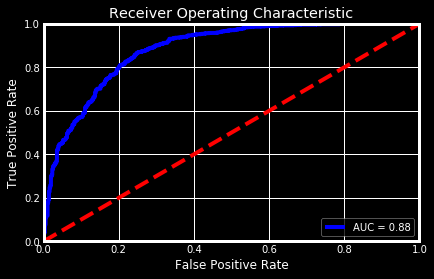

In [186]:
xgb1 = XGBClassifier(**optimum, verbose = 3)
t0 = datetime.datetime.now()
print('---------------------------------------------------')

print('Fitting XGBoost...')
xgb1.fit(X1_train_resampled, y1_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('---------------------------------------------------')
print('Predicting on validation data...')
y1_pred_probas = xgb1.predict_proba(X1_val_imputed)
y1_pred_proba = y1_pred_probas[:,1]
y1_pred = xgb1.predict(X1_val_imputed)

print('Predictions Completed')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('---------------------------------------------------')
print('ROC-AUC Score: {:.2%}'.format(roc_auc_score(y1_val, y1_pred_proba)))
print('Accuracy Score: {:.2%}'.format(accuracy_score(y1_val, y1_pred)))
print('Precision Score: {:.2%}'.format(precision_score(y1_val, y1_pred)))
print('Recall Score: {:.2%}'.format(recall_score(y1_val, y1_pred)))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y1_val, y1_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y1_val, y1_pred)).loc[range(2), range(2)]
print(confusion)

plot_roc(y1_val, y1_pred_proba)